In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from acv_explainers import ACVTree
from acv_explainers.utils import *
from experiments.exp_linear_gmm import *

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns

import random 
import numpy as np
import pandas as pd

random.seed(212)
np.random.seed(212)

plt.style.use('ggplot')

### Load data and model

In [2]:
X = pd.read_csv('/data/lucas0_train.csv')
X.head()

y = X.Lung_cancer.values
X.drop(['Lung_cancer'], axis=1, inplace=True)

n_estimators = 1
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Model 
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=212)
tree.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

forest = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=5, random_state=212, 
                                max_samples=0.8, max_depth=4)
forest.fit(X_train, y_train)
forest.estimators_[0] = tree

accuracy_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

[* TREE *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667
[* FOREST *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667


### Let's choose an observation to explain

In [3]:
# idx = np.random.randint(0, 400)
idx = 160
ind = X_test.values[idx]
y_ind = y_test[idx]
fx = forest.predict(np.expand_dims(ind, 0))[0]
print('f(x) = {}, y_ind = {}'.format(fx, y_ind))
X_test[idx:idx+1]

f(x) = 1, y_ind = 1


,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing
174,1,1,1,1,1,1,0,1,1,0,1


### Build ACVTree for explanations

In [4]:
acvtree = ACVTree(forest, X_train.values)

100%|██████████| 1/1 [00:00<00:00, 152.55it/s]


In [5]:
columns_names = [X.columns[i] for i in range(X.shape[1])]
data = np.array(X_train.values, dtype=np.double)

### Find $S^\star$

In [7]:
# params init 
x = np.expand_dims(ind, 0)
global_proba = 0.9
index = list(range(X.shape[1]))
sdp_cluster = []
sdp_importance, sdp_index, size, sdp = acvtree.importance_sdp_clf(X=x, data=data, C=[[]], global_proba=global_proba)
sdp_cluster = [[sdp_index[0, i] for i in range(size[0])]]
sdp_cluster += [list(set(index) - set(sdp_cluster[0]))]

print('Cluster find by SDP = {}'.format(sdp_cluster[0]))

sdp_importance_cluster = []
for c in sdp_cluster:     
    sdp_importance_cluster.append(acvtree.compute_sdp_clf(x, S=np.array(c), data=data))

sdp_importance_cluster = np.array(sdp_importance_cluster).reshape(-1)

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str([X.columns[i] for i in c]))

  8%|▊         | 1/12 [00:00<00:00, 39.86it/s]

Cluster find by SDP = [10]


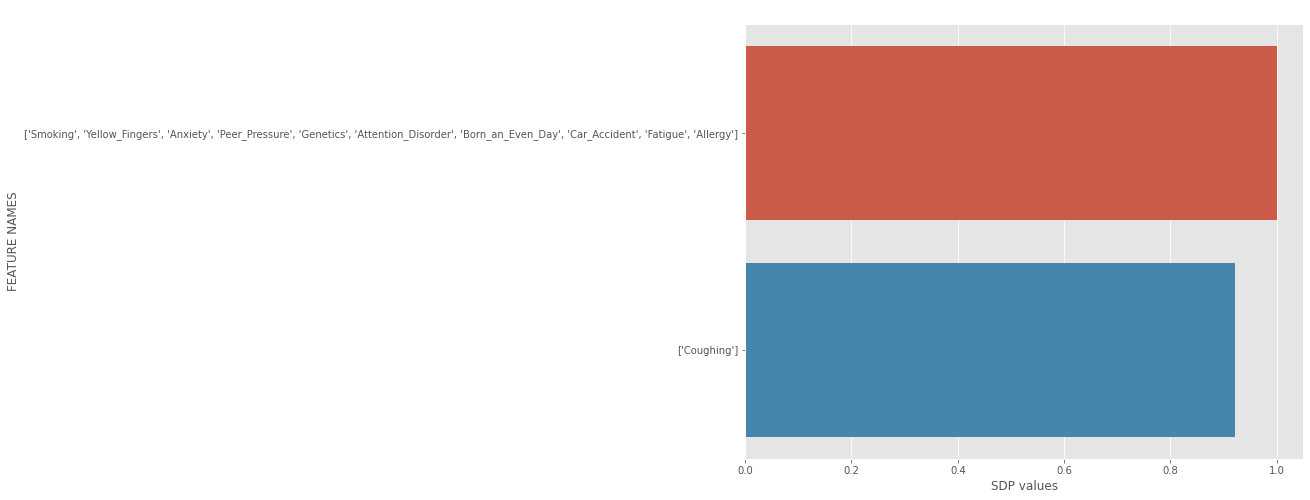

In [8]:
plot_feature_importance(sdp_importance_cluster, sdp_importance_name, 'forest_SDP  ', xlabel='SDP values', title=' ')

In [9]:
x = np.expand_dims(ind, 0)

In [10]:
thresholds = 0.9

In [11]:
sv, swing, swing_prop = acvtree.swing_sv_clf(X=x, thresholds=thresholds, data=data, C=[[]])

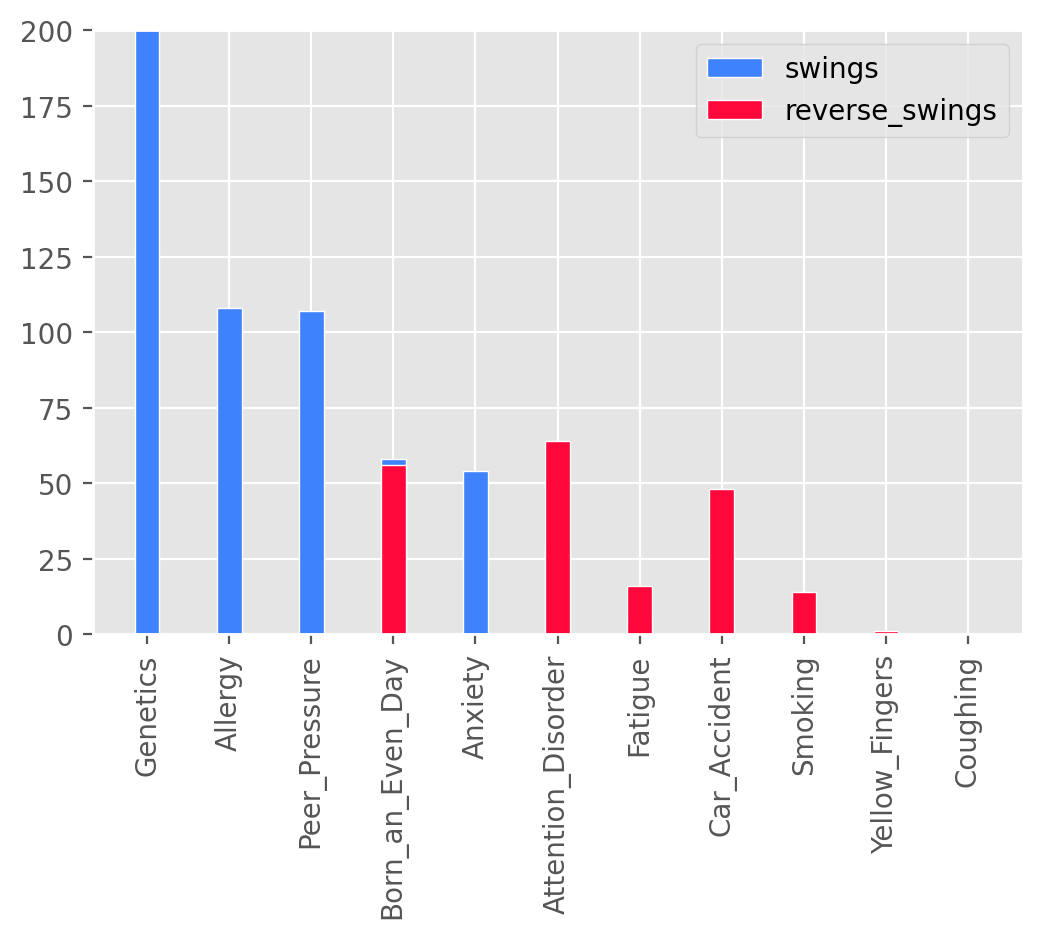

In [12]:
n = 11
d = 11
X = np.arange(n)
# Y1 = (1-X/float(n)) * np.random.uniform(0.5,1.0,n)
# Y2 = (1-X/float(n)) * np.random.uniform(0.5,1.0,n)
plt.figure(dpi=200)
columns_names = [X_train.columns[i] for i in range(X_train.shape[1])]
labels = columns_names

nb_swings = swing_prop[0, :, 0]
nb_revers_swings = swing_prop[0, :, 1]

data = {'feature_names': columns_names, 'nb_swings': nb_swings, 'nb_revers_swings':nb_revers_swings}

fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['nb_swings'], ascending=False, inplace=True)

plt.bar(X, fi_df.nb_swings, facecolor='#3e82fc', edgecolor='white', label='swings', width=0.3)
plt.bar(X, fi_df.nb_revers_swings, facecolor='#ff073a', edgecolor='white', label='reverse_swings', width=0.3)

# i = 0
# for x,y in zip(X,nb_swings):
#     plt.text(x+0.07, y, '%.2f' % y, ha='center', va= 'bottom')
#     plt.text(x+0.07, nb_revers_swings[i]-0.02, '%.2f' % nb_revers_swings[i], ha='center', va= 'bottom')
#     i = i + 1
    
plt.ylim(np.min(nb_revers_swings), np.max(nb_swings))
plt.legend()
plt.xticks([r for r in range(len(nb_swings))], fi_df.feature_names, rotation='vertical')

plt.show()

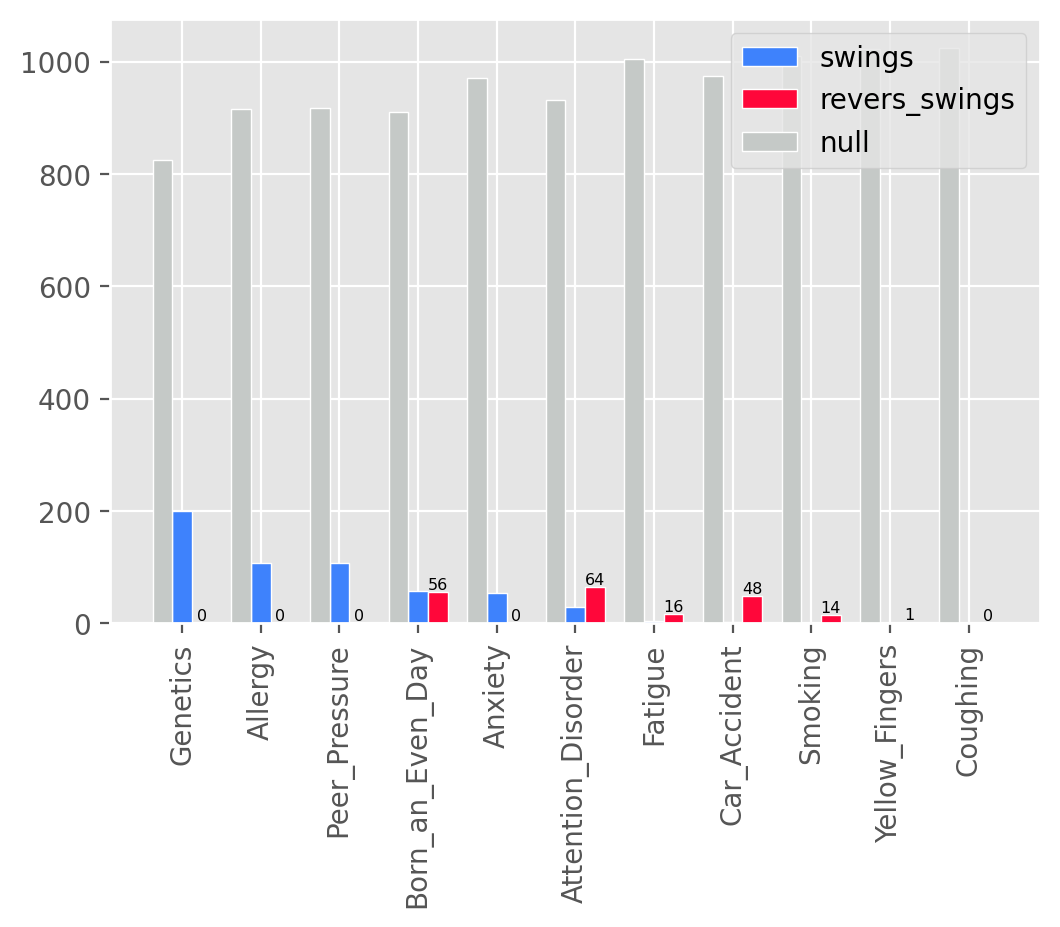

In [13]:
import numpy as np
import matplotlib.pyplot as plt
p_idx = 11
# set width of bar
barWidth = 0.5
 
# set height of bar
# labels = list(swings[0].keys())
columns_names = [X_train.columns[i] for i in range(X_train.shape[1])]
labels = columns_names
nb_swings = swing_prop[0, :, 0]
nb_revers_swings = swing_prop[0, :, 1]
nb_null = swing_prop[0, :, 2]

data = {'feature_names': columns_names, 'nb_swings': nb_swings, 'nb_revers_swings':nb_revers_swings,
       'nb_null':nb_null}

fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['nb_swings'], ascending=False, inplace=True)

# Set position of bar on X axis
r1 = 2*np.arange(len(nb_swings))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig, ax = plt.subplots(dpi=200)
# Make the plot
plt.bar(r2, fi_df.nb_swings, color='#3e82fc', width=barWidth, edgecolor='white', label='swings')
plt.bar(r3, fi_df.nb_revers_swings, color='#ff073a', width=barWidth, edgecolor='white', label='revers_swings')
plt.bar(r1, fi_df.nb_null, color='#c5c9c7', width=barWidth, edgecolor='white', label='null')
 
# i = 0
for x,y in zip(r3, fi_df.nb_revers_swings):
    plt.text(x, y, '{}'.format(int(y)), ha='center', va= 'bottom', fontsize='xx-small')
#     plt.text(x+0.07, nb_revers_swings[i]-0.02, '%.2f' % nb_revers_swings[i], ha='center', va= 'bottom')
#     i = i + 1
# Add xticks on the middle of the group bars
# plt.xlabel('Proportion of swings, revers_swings, null', fontweight='bold')
plt.xticks([2*r + barWidth for r in range(len(nb_swings))], fi_df.feature_names, rotation='vertical')
 
# Create legend & Show graphic
plt.legend()
# plt.title('Number of swings, revers_swings, null')
plt.show()